In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import graph_policy
graph_policy.VARIABLE_NUM = 10

In [3]:
from graph_policy import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnfs, CNF

In [4]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
META_FILE = "models/activepolicy-18-04-02-015404/model-8797184.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/activepolicy-18-04-02-015404/model-8797184


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [6]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
LEVEL = 10

In [8]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [9]:
np.set_printoptions(precision=3, suppress=True)

In [10]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [11]:
import pycosat

In [12]:
import time
from functools import wraps
def measured(func):
    @wraps(func)
    def new_func(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        end = time.time()
        return results, (end - start)
    return new_func

In [13]:
@measured
def solve_graph(cnf: CNF):
    dpll = GraphBasedDPLL()
    res = dpll.run(cnf)
    steps = dpll.number_of_runs
    errors = dpll.number_of_errors
    return res, steps, errors

@measured
def solve_pyco(cnf: CNF):
    return pycosat.solve(cnf.clauses)

In [14]:
from numpy import mean

In [15]:
def get_avg_stats(cnfs):
    times = []
    timesp = []
    steps = []
    errors = []
    sat_count = 0
    for cnf in cnfs:
        resp, timp = solve_pyco(cnf)
        if resp == 'UNSAT':
            continue
        (resg, stepg, errg), timg = solve_graph(cnf)
        #print(timp, timg/BATCH_SIZE, 'UNSAT' if resp == 'UNSAT' else 'SAT')
        times.append(timg)
        timesp.append(timp)
        steps.append(stepg)
        errors.append(errg)
        sat_count += 1
    return mean(times), mean(timesp), mean(steps), mean(errors), sat_count

def get_avg_stats_for(var_num, clause_num, sample=100):
    cnfs = get_random_kcnfs(sample, 3, var_num, clause_num, min_clause_number=clause_num)
    return get_avg_stats(cnfs)

In [16]:
def get_avg_stats_for_range(var_nums, clause_nums, sample=5):
    times = []
    timesp = []
    steps = []
    errors = []
    sat_counts = []
    for var_num, clause_num in zip(var_nums, clause_nums):
        print("Computing {}, {}, ".format(var_num, clause_num), end="")
        tim, timp, step, error, sat_count = get_avg_stats_for(var_num, clause_num, sample)
        print(tim*sample)
        times.append(tim)
        timesp.append(timp)
        steps.append(step)
        errors.append(error)
        sat_counts.append(sat_count)
    return times, timesp, steps, errors, sat_counts

In [24]:
def plot_avg_stats_for_range(var_nums, clause_nums, sample=5, versus=None):
    times, timesp, steps, errors, sat_counts = get_avg_stats_for_range(var_nums, clause_nums, sample)
    plt.title("Times vs {}".format(versus))
    plt.plot(times, label='graph')
    plt.plot(timesp, label='pycosat')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.title("Steps vs {}".format(versus))
    plt.plot(steps)
    plt.show()
    plt.title("Errors vs {}".format(versus))
    plt.plot(errors)
    plt.show()
    plt.title("Sat count vs {}".format(versus))
    plt.plot(sat_counts)
    plt.show()

Computing 3, 0, 4.1484832763671875e-05
Computing 3, 1, 0.216569185256958
Computing 3, 2, 0.138075590133667
Computing 3, 3, 0.22872018814086914
Computing 3, 4, 0.17291784286499023
Computing 3, 5, 0.17655014991760254
Computing 3, 6, 0.1909499168395996
Computing 3, 7, 0.2080690860748291
Computing 3, 8, 0.15351080894470215
Computing 3, 9, 0.19828399022420246
Computing 3, 10, 0.18961668014526367
Computing 3, 11, 0.17253319422403973
Computing 3, 12, 0.36919355392456055
Computing 3, 13, 0.22048200879778182
Computing 3, 14, 0.41443041392735075
Computing 3, 15, 0.20846694707870483
Computing 3, 16, 0.2441883087158203
Computing 3, 17, 0.2699470520019531
Computing 3, 18, 0.274324893951416
Computing 3, 19, 0.22461334864298504


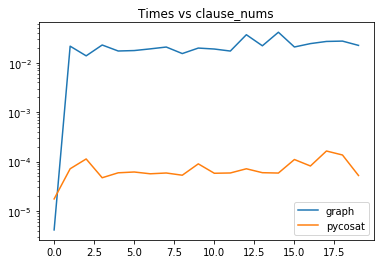

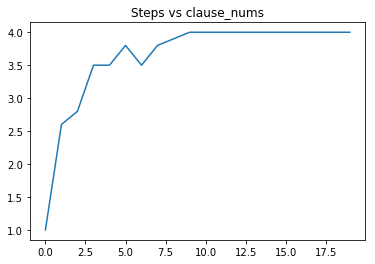

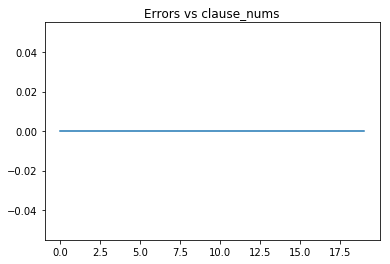

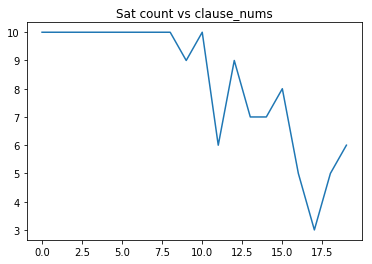

In [25]:
RANGE = 30
plot_avg_stats_for_range([3]*RANGE, range(20), sample=10, versus="clause_nums")

Computing 0, 0, 1.430511474609375e-05
Computing 1, 4, 0.03367447853088379
Computing 2, 8, 0.056341588497161865
Computing 3, 12, 0.08780320485432944
Computing 4, 16, 0.14998157819112143
Computing 5, 20, 0.18810606002807617
Computing 6, 24, 0.24488170941670734
Computing 7, 28, 0.4376697540283203
Computing 8, 32, 0.35851478576660156
Computing 9, 36, 0.9391236305236816
Computing 10, 40, 0.5592870712280273
Computing 11, 44, 0.5968451499938965
Computing 12, 48, 0.6321144104003906
Computing 13, 52, 1.1359024047851562
Computing 14, 56, 0.8367457389831543
Computing 15, 60, 1.0443240404129028
Computing 16, 64, 1.1859571933746338
Computing 17, 68, 1.4108750224113464
Computing 18, 72, 1.3426482677459717
Computing 19, 76, 1.2375108400980632
Computing 20, 80, 1.8662899732589722
Computing 21, 84, 1.9355015754699707
Computing 22, 88, 2.0784544944763184
Computing 23, 92, 2.065183718999227
Computing 24, 96, 2.2246972719828286
Computing 25, 100, 2.5992944836616516
Computing 26, 104, 2.903623580932617
Com

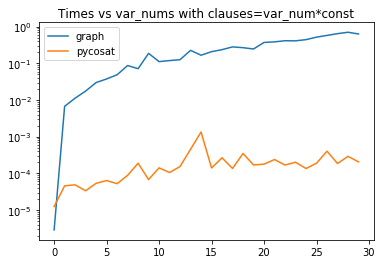

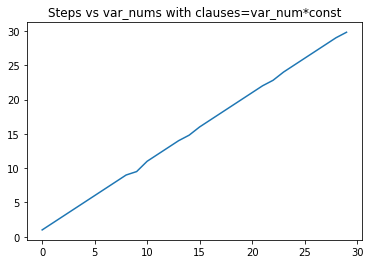

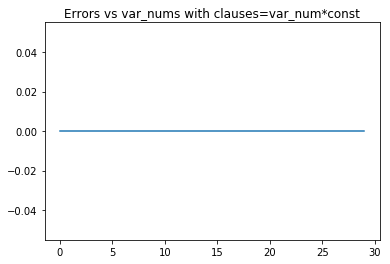

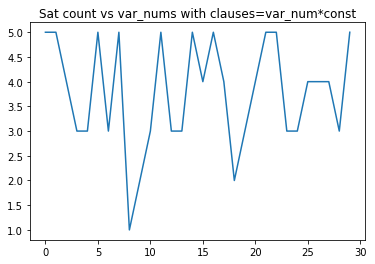

In [26]:
VAR_NUMS = range(30)
CLAUSE_NUMS = [int(var_num*4.0) for var_num in VAR_NUMS]
plot_avg_stats_for_range(VAR_NUMS, CLAUSE_NUMS, sample=5, versus="var_nums with clauses=var_num*const")